# Recommender systems

## One of the most common uses of big data is to predict and suggest what users may want.  This allows Google to show you relevant ads or to suggest news in Google Now; Amazon to recommend relevant products; Netflix to recommend movies that you might like; or most recently, the famous **Weekly Dicovery** of Spotify.

## All these products are based on systems of recommendation: a information retrieval method to provide users with relevant, yet novel and diverse, information. 

## In this class we will use a pretty famous dataset based on movies ratings, 'MovieLens', to learn the basics of recommender systems. 

## Table of Contents (times are approximated)

1. [Getting and analysing some data (~1:30 h)](#data)
2. [Most popular movies (~30 min)](#popular)
3. [Metrics for recommender systems (~1.30h)](#metrics)
4. [Collaborative Filtering (~15 min)](#cf)  
   4.1 [Co-occurrence Matrix (~1.30h)](#copurchase)
   <br></br>
   4.2 [Memory-based CF (~1 h)](#memory-base)
   <br></br>
   4.3 [Model-based CF (~2 h)](#model-base)

In [64]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import io
import os

<a id='data'></a>
## 1.1 Load data

We will use MovieLens dataset, which is one of the most common datasets used when implementing and testing recommender engines. This data set consists of:
* 100,000 ratings (1-5) from 943 users on 1682 movies. 
* Each user has rated at least 20 movies. 
* Simple demographic info for the users (age, gender, occupation, zip)

The data was collected through the MovieLens [website](https://movielens.org) during the seven-month period from September 19th, 
1997 through April 22nd, 1998. This data has been cleaned up - users
who had less than 20 ratings or did not have complete demographic
information were removed from this data set.

You can download the dataset [here](http://files.grouplens.org/datasets/movielens/ml-100k.zip).

Take a look at the readme file!!!

In [65]:
!ls ./data/

ml-100k


In [66]:
data_root = "./data/ml-100k/"
readme = os.path.join(data_root, "README")
!cat $readme

SUMMARY & USAGE LICENSE

MovieLens data sets were collected by the GroupLens Research Project
at the University of Minnesota.
 
This data set consists of:
	* 100,000 ratings (1-5) from 943 users on 1682 movies. 
	* Each user has rated at least 20 movies. 
        * Simple demographic info for the users (age, gender, occupation, zip)

The data was collected through the MovieLens web site
(movielens.umn.edu) during the seven-month period from September 19th, 
1997 through April 22nd, 1998. This data has been cleaned up - users
who had less than 20 ratings or did not have complete demographic
information were removed from this data set. Detailed descriptions of
the data file can be found at the end of this file.

Neither the University of Minnesota nor any of the researchers
involved can guarantee the correctness of the data, its suitability
for any particular purpose, or the validity of results based on the
use of the data set.  The data set may be used for any research
purposes under th

In [67]:
columns = ['user_id', 'item_id', 'rating', 'timestamp']
datafile = os.path.join(data_root, "u.data")
data = pd.read_csv(datafile, sep='\t', names=columns)
data.head()

,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [68]:
n_users = data.user_id.unique().shape[0]
n_items = data.item_id.unique().shape[0]
print("There are %s users and %s items" %(n_users, n_items))

There are 943 users and 1682 items


In [70]:
data.values[:20]

array([[      196,       242,         3, 881250949],
       [      186,       302,         3, 891717742],
       [       22,       377,         1, 878887116],
       [      244,        51,         2, 880606923],
       [      166,       346,         1, 886397596],
       [      298,       474,         4, 884182806],
       [      115,       265,         2, 881171488],
       [      253,       465,         5, 891628467],
       [      305,       451,         3, 886324817],
       [        6,        86,         3, 883603013],
       [       62,       257,         2, 879372434],
       [      286,      1014,         5, 879781125],
       [      200,       222,         5, 876042340],
       [      210,        40,         3, 891035994],
       [      224,        29,         3, 888104457],
       [      303,       785,         3, 879485318],
       [      122,       387,         5, 879270459],
       [      194,       274,         2, 879539794],
       [      291,      1042,         4, 87483

In [71]:
data.values[19, :2]

array([ 234, 1184], dtype=int64)

In [72]:
data.values[:, 2]

array([3, 3, 1, ..., 1, 2, 3], dtype=int64)

## 1.2 A dictionary for movies and a search tool

In order to analyze the predicted recommendations, let's create a python dictonary that will allow us to translate any item id to the corresponding movie title. Also, let's write a small function that returns the ids of the movies containing some text.

The correspondance between titles and ids is stored in the u.item file

In [73]:
data_root = "./data/ml-100k/"
items_id_file = os.path.join(data_root, "u.item")
!head $items_id_file

1|Toy Story (1995)|01-Jan-1995||http://us.imdb.com/M/title-exact?Toy%20Story%20(1995)|0|0|0|1|1|1|0|0|0|0|0|0|0|0|0|0|0|0|0
2|GoldenEye (1995)|01-Jan-1995||http://us.imdb.com/M/title-exact?GoldenEye%20(1995)|0|1|1|0|0|0|0|0|0|0|0|0|0|0|0|0|1|0|0
3|Four Rooms (1995)|01-Jan-1995||http://us.imdb.com/M/title-exact?Four%20Rooms%20(1995)|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|1|0|0
4|Get Shorty (1995)|01-Jan-1995||http://us.imdb.com/M/title-exact?Get%20Shorty%20(1995)|0|1|0|0|0|1|0|0|1|0|0|0|0|0|0|0|0|0|0
5|Copycat (1995)|01-Jan-1995||http://us.imdb.com/M/title-exact?Copycat%20(1995)|0|0|0|0|0|0|1|0|1|0|0|0|0|0|0|0|1|0|0
6|Shanghai Triad (Yao a yao yao dao waipo qiao) (1995)|01-Jan-1995||http://us.imdb.com/Title?Yao+a+yao+yao+dao+waipo+qiao+(1995)|0|0|0|0|0|0|0|0|1|0|0|0|0|0|0|0|0|0|0
7|Twelve Monkeys (1995)|01-Jan-1995||http://us.imdb.com/M/title-exact?Twelve%20Monkeys%20(1995)|0|0|0|0|0|0|0|0|1|0|0|0|0|0|0|1|0|0|0
8|Babe (1995)|01-Jan-1995||http://us.imdb.com/M/title-exact?Babe%20(1995)|0|0|0|0|1

In [74]:
# Create a dictionary for movie titles and ids
item_dict = {}
with io.open(items_id_file, 'rb') as f:
    for line in f.readlines():
        record = line.split(b'|')
        item_dict[int(record[0])] = str(record[1])
    
# We can use this dict to see the films a user has seen, for instance. 
for record in data.values[:20]:
    print("User {u} viewed '{m}' and gave a {r} rating".format(u=record[0], m=item_dict[record[1]], r=record[2]))    

User 196 viewed 'b'Kolya (1996)'' and gave a 3 rating
User 186 viewed 'b'L.A. Confidential (1997)'' and gave a 3 rating
User 22 viewed 'b'Heavyweights (1994)'' and gave a 1 rating
User 244 viewed 'b'Legends of the Fall (1994)'' and gave a 2 rating
User 166 viewed 'b'Jackie Brown (1997)'' and gave a 1 rating
User 298 viewed 'b'Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1963)'' and gave a 4 rating
User 115 viewed 'b'Hunt for Red October, The (1990)'' and gave a 2 rating
User 253 viewed 'b'Jungle Book, The (1994)'' and gave a 5 rating
User 305 viewed 'b'Grease (1978)'' and gave a 3 rating
User 6 viewed 'b'Remains of the Day, The (1993)'' and gave a 3 rating
User 62 viewed 'b'Men in Black (1997)'' and gave a 2 rating
User 286 viewed 'b"Romy and Michele's High School Reunion (1997)"' and gave a 5 rating
User 200 viewed 'b'Star Trek: First Contact (1996)'' and gave a 5 rating
User 210 viewed 'b'To Wong Foo, Thanks for Everything! Julie Newmar (1995)'' and gave a 3 

In [75]:
# Define a function that retrieves all the ids and titles for movies containing 'text' in its title
def returnItemId(text, ids):
    """
    :param text: string to be looked for in movies titles
    :param ids: dicttionary of {id:title}
    
    :return: a list of (id,title) if text found in titles, and an empty list otherwise.
    """
    search = [(k, v.lower().find(text.lower())) 
              for k,v in list(ids.items())]
    index = [k for k,v in search if v>-1]
    
    return list(zip(index, [ids[i] for i in index]) if len(index)>0 else [])

In [76]:
returnItemId??

In [77]:
returnItemId('but', item_dict)

[(240, "b'Beavis and Butt-head Do America (1996)'"),
 (435, "b'Butch Cassidy and the Sundance Kid (1969)'"),
 (580,
  "b'Englishman Who Went Up a Hill, But Came Down a Mountain, The (1995)'"),
 (1401, "b'M. Butterfly (1993)'"),
 (1459, "b'Madame Butterfly (1995)'"),
 (1614, "b'Reluctant Debutante, The (1958)'"),
 (1621, "b'Butterfly Kiss (1995)'"),
 (1645, "b'Butcher Boy, The (1998)'"),
 (1650, "b'Butcher Boy, The (1998)'")]

## 1.3 Data consistency (always double check everything!!!)

In [78]:
# print a couple of duplicated titles
with io.open(items_id_file, 'rb') as f:
    <fill in>

SyntaxError: invalid syntax (<ipython-input-78-81ec63d44508>, line 3)

In [79]:
# check whether titles are unique or not
print(len(set(item_dict.keys())))
print(len(set(item_dict.values())))

1682
1664


### One work around: create another dict that consolidates ids with the same movie title

In [80]:
duplicates_item_dict = {}
i = 0
for id,name in list(item_dict.items()):
    if name not in duplicates_item_dict:
        duplicates_item_dict[name] = [id]
    else:
        duplicates_item_dict[name] = duplicates_item_dict[name]+[id]

# show hte duplicated titles
for k,v in list(duplicates_item_dict.items()):
    if len(v)>1:
        print(k,v)

b'Chasing Amy (1997)' [246, 268]
b'Kull the Conqueror (1997)' [266, 680]
b"Ulee's Gold (1997)" [297, 303]
b'Fly Away Home (1996)' [304, 500]
b'Ice Storm, The (1997)' [305, 865]
b'Deceiver (1997)' [309, 1606]
b'Desperate Measures (1998)' [329, 348]
b'Body Snatchers (1993)' [573, 670]
b'Substance of Fire, The (1996)' [711, 1658]
b'Money Talks (1997)' [876, 881]
b'That Darn Cat! (1997)' [878, 1003]
b'Hugo Pool (1997)' [1175, 1617]
b'Chairman of the Board (1998)' [1234, 1654]
b'Designated Mourner, The (1997)' [1256, 1257]
b'Hurricane Streets (1998)' [1395, 1607]
b'Sliding Doors (1998)' [1429, 1680]
b'Nightwatch (1997)' [1477, 1625]
b'Butcher Boy, The (1998)' [1645, 1650]


Create a dict where the key are the original ids, and the values are the unique one. 
We will use this dictionary to remove duplicates in a dataframe.

In [81]:
unique_id_item_dict ={}
for id_nuevo, lista_id_viejo in enumerate(duplicates_item_dict.values()) :
    for id_viejo in lista_id_viejo:
        unique_id_item_dict[id_viejo] = id_nuevo

Create another dict mapping moving titles to this new unique id

In [82]:
unique_item_dict = {unique_id_item_dict[k]:v 
                    for k,v in item_dict.items()}
assert(len(set(unique_item_dict.keys())) == 
       len(set(unique_item_dict.values())))

In [83]:
len(set(item_dict.values()))

1664

In [84]:
len(set(unique_item_dict.values()))

1664

Now we can use our `returnItemId()` mehtod safely =)

In [85]:
returnItemId('but', unique_item_dict)

[(239, "b'Beavis and Butt-head Do America (1996)'"),
 (431, "b'Butch Cassidy and the Sundance Kid (1969)'"),
 (575,
  "b'Englishman Who Went Up a Hill, But Came Down a Mountain, The (1995)'"),
 (1390, "b'M. Butterfly (1993)'"),
 (1448, "b'Madame Butterfly (1995)'"),
 (1601, "b'Reluctant Debutante, The (1958)'"),
 (1607, "b'Butterfly Kiss (1995)'"),
 (1630, "b'Butcher Boy, The (1998)'")]

In [86]:
returnItemId('but', item_dict)

[(240, "b'Beavis and Butt-head Do America (1996)'"),
 (435, "b'Butch Cassidy and the Sundance Kid (1969)'"),
 (580,
  "b'Englishman Who Went Up a Hill, But Came Down a Mountain, The (1995)'"),
 (1401, "b'M. Butterfly (1993)'"),
 (1459, "b'Madame Butterfly (1995)'"),
 (1614, "b'Reluctant Debutante, The (1958)'"),
 (1621, "b'Butterfly Kiss (1995)'"),
 (1645, "b'Butcher Boy, The (1998)'"),
 (1650, "b'Butcher Boy, The (1998)'")]

## 1.4 Train and test sets

GroupLens provides several splits of the dataset, so that we can check the goodness of our algorithms. See the README file for more  details. Here we will use one of such splits.

Please notice that we have to correct for the non-unique movie's id issue!!

In [87]:
!ls $data_root

README
allbut.pl
mku.sh
u.data
u.genre
u.info
u.item
u.occupation
u.user
u1.base
u1.test
u2.base
u2.test
u3.base
u3.test
u4.base
u4.test
u5.base
u5.test
ua.base
ua.test
ub.base
ub.test


In [88]:
trainfile = os.path.join(data_root, 'ua.base')
!head $trainfile

1	1	5	874965758
1	2	3	876893171
1	3	4	878542960
1	4	3	876893119
1	5	3	889751712
1	6	5	887431973
1	7	4	875071561
1	8	1	875072484
1	9	5	878543541
1	10	3	875693118


In [89]:
columns = ['user_id', 'item_id', 'rating', 'timestamp']
trainfile = os.path.join(data_root, "ua.base")
train = pd.read_csv(trainfile, sep='\t', names=columns)
print('There are %s users, %s itmes and %s pairs in the train set' \
      %(train.user_id.unique().shape[0], train.item_id.unique().shape[0], train.shape[0]))
train.head()


There are 943 users, 1680 itmes and 90570 pairs in the train set


,user_id,item_id,rating,timestamp
0,1,1,5,874965758
1,1,2,3,876893171
2,1,3,4,878542960
3,1,4,3,876893119
4,1,5,3,889751712


In [90]:
columns = ['user_id', 'item_id', 'rating', 'timestamp']
testfile = os.path.join(data_root, "ua.test")
test = pd.read_csv(testfile, sep='\t', names=columns)
print('There are %s users, %s itmes and %s pairs in the test set' \
      %(test.user_id.unique().shape[0], test.item_id.unique().shape[0], test.shape[0]))
test.head()


There are 943 users, 1129 itmes and 9430 pairs in the test set


,user_id,item_id,rating,timestamp
0,1,20,4,887431883
1,1,33,4,878542699
2,1,61,4,878542420
3,1,117,3,874965739
4,1,155,2,878542201


### Correcting for non-unique movies id 

In [91]:
train['item_id'] = train['item_id'].apply(
    lambda id: unique_id_item_dict[id])
print('Now there are %s unique items in traint set' 
      % train.item_id.unique().shape[0])

Now there are 1662 unique items in traint set


In [92]:
test['item_id'] = test['item_id'].apply(
    lambda id: unique_id_item_dict[id])
print('Now there are %s unique items in test set' 
      % test.item_id.unique().shape[0])

Now there are 1119 unique items in test set


<a id='popular'></a>
## 2. Most popular movies

Recommending popular items is a simple, yet quite effective baseline for recommendation. Indeed, most RS suffer from a strong *popularity bias*, i.e. they tend to recommend popular items more frequently than they should -just because suggesting what is popular is effective!-. There is a lot of research  devote to understand this behaviour and to develop recipies to avoid it. 

Movies can be ranked according to different popularity metrics:
* Most rated movie (it is assumed that this is the most watched movie)
* Most positively rated movie (rating > 4.0)
* Highest rated movie

## 2.1 Most rated movie

In [93]:
train.head(5)

,user_id,item_id,rating,timestamp
0,1,0,5,874965758
1,1,1,3,876893171
2,1,2,4,878542960
3,1,3,3,876893119
4,1,4,3,889751712


In [94]:
# group the train dataset by item and count the number of users using Pandas
mostRated = train.groupby('item_id')['user_id'].count()

In [95]:
# sort in descending order
mostRatedSorted = mostRated.sort_values(ascending=False)

In [96]:
mostRatedSorted.head()

item_id
49     495
99     443
180    439
257    412
284    400
Name: user_id, dtype: int64

In [97]:
# Return a numpy array of np.array([id, title, frequency])
mostRatedMovies = np.array(
    [np.array([row, unique_item_dict[row], 
               mostRatedSorted[row]], dtype=np.object)
     for row in mostRatedSorted.index])
mostRatedMovies[:10,1:]

array([["b'Star Wars (1977)'", 495],
       ["b'Fargo (1996)'", 443],
       ["b'Return of the Jedi (1983)'", 439],
       ["b'Contact (1997)'", 412],
       ["b'English Patient, The (1996)'", 400],
       ["b'Liar Liar (1997)'", 398],
       ["b'Toy Story (1995)'", 392],
       ["b'Scream (1996)'", 386],
       ["b'Independence Day (ID4) (1996)'", 384],
       ["b'Raiders of the Lost Ark (1981)'", 379]], dtype=object)

## 2.2 Most positively rated movie

In [98]:
# filter movies rated with rating >=4.0. Then group by item, count the number of users and sort in descending order.
positiveRated = train[train.rating>=4.0].groupby('item_id')['user_id'].count().sort_values(ascending=False)

In [99]:
positiveRated.head()

item_id
49     428
99     354
180    331
173    316
97     310
Name: user_id, dtype: int64

In [100]:
# Return a numpy array of np.array([id, title, frequency])
positiveRatedMovies = np.array(
    [np.array([row, unique_item_dict[row], 
               positiveRated[row]], dtype=np.object)
     for row in positiveRated.index])
positiveRatedMovies[:10,1:]

array([["b'Star Wars (1977)'", 428],
       ["b'Fargo (1996)'", 354],
       ["b'Return of the Jedi (1983)'", 331],
       ["b'Raiders of the Lost Ark (1981)'", 316],
       ["b'Silence of the Lambs, The (1991)'", 310],
       ["b'Godfather, The (1972)'", 298],
       ["b'Contact (1997)'", 276],
       ["b'Toy Story (1995)'", 275],
       ["b'Empire Strikes Back, The (1980)'", 264],
       ["b'Pulp Fiction (1994)'", 262]], dtype=object)

## 2.3 Highest mean rating movie

In [101]:
# obtaine the highest rated movies, with a minium number of users/ratings.
min_ratings = 150

# group the ratings by item and stack them in a list
listRatedMovies = train.groupby('item_id')['rating'].apply(list).reset_index()

In [102]:
listRatedMovies.head()

,item_id,rating
0,0,"[5, 4, 4, 4, 3, 1, 5, 5, 3, 5, 5, 5, 3, 5, 4, ..."
1,1,"[3, 3, 2, 3, 5, 1, 3, 3, 4, 4, 3, 2, 2, 3, 4, ..."
2,2,"[4, 2, 3, 4, 3, 2, 2, 1, 3, 3, 5, 3, 3, 3, 2, ..."
3,3,"[3, 5, 4, 5, 5, 5, 3, 5, 4, 2, 4, 4, 3, 3, 2, ..."
4,4,"[3, 1, 2, 3, 4, 4, 4, 3, 3, 2, 4, 3, 3, 4, 3, ..."


In [103]:
# filter movies with a minimum number of ratings
mask = listRatedMovies.rating.apply(lambda x: len(x)>min_ratings)
filteredListRatedMovies = listRatedMovies[mask]

In [104]:
filteredListRatedMovies.head()

,item_id,rating
0,0,"[5, 4, 4, 4, 3, 1, 5, 5, 3, 5, 5, 5, 3, 5, 4, ..."
3,3,"[3, 5, 4, 5, 5, 5, 3, 5, 4, 2, 4, 4, 3, 3, 2, ..."
6,6,"[4, 2, 5, 3, 4, 2, 5, 1, 5, 4, 5, 4, 4, 4, 3, ..."
7,7,"[1, 4, 5, 4, 4, 5, 5, 4, 5, 4, 4, 3, 4, 4, 3, ..."
8,8,"[5, 4, 5, 4, 5, 3, 4, 4, 5, 5, 5, 5, 4, 4, 3, ..."


In [105]:
# obtain the mean of the list of rating per movie
meanMovies = filteredListRatedMovies.rating.apply(np.mean).sort_values(ascending=False)

In [106]:
meanMovies.head()

315    4.475836
479    4.459821
63     4.457364
11     4.386454
598    4.374359
Name: rating, dtype: float64

In [107]:
# Return a numpy array of np.array([id, title, frequency])
meanRateMovies = np.array(
    [np.array([row, unique_item_dict[row], 
               meanMovies[row]], dtype=np.object)
     for row in meanMovies.index])

meanRateMovies[:10,1:]

array([['b"Schindler\'s List (1993)"', 4.4758364312267656],
       ["b'Casablanca (1942)'", 4.4598214285714288],
       ["b'Shawshank Redemption, The (1994)'", 4.4573643410852712],
       ["b'Usual Suspects, The (1995)'", 4.3864541832669319],
       ["b'Rear Window (1954)'", 4.3743589743589739],
       ["b'Star Wars (1977)'", 4.3656565656565656],
       ["b'To Kill a Mockingbird (1962)'", 4.3232323232323235],
       ["b'Citizen Kane (1941)'", 4.3206521739130439],
       ["b'Silence of the Lambs, The (1991)'", 4.3114285714285714],
       ['b"One Flew Over the Cuckoo\'s Nest (1975)"', 4.2921810699588478]], dtype=object)

In [108]:
# Return a numpy array of np.array([id, title, frequency])
meanRateMovies = np.array(
    [np.array([row, unique_item_dict[row], 
               meanMovies[row]], dtype=np.object)
     for row in meanMovies.index])

meanRateMovies[:10,1:]

array([['b"Schindler\'s List (1993)"', 4.4758364312267656],
       ["b'Casablanca (1942)'", 4.4598214285714288],
       ["b'Shawshank Redemption, The (1994)'", 4.4573643410852712],
       ["b'Usual Suspects, The (1995)'", 4.3864541832669319],
       ["b'Rear Window (1954)'", 4.3743589743589739],
       ["b'Star Wars (1977)'", 4.3656565656565656],
       ["b'To Kill a Mockingbird (1962)'", 4.3232323232323235],
       ["b'Citizen Kane (1941)'", 4.3206521739130439],
       ["b'Silence of the Lambs, The (1991)'", 4.3114285714285714],
       ['b"One Flew Over the Cuckoo\'s Nest (1975)"', 4.2921810699588478]], dtype=object)

In [109]:
mostRatedMovies[:10, 1:]

array([["b'Star Wars (1977)'", 495],
       ["b'Fargo (1996)'", 443],
       ["b'Return of the Jedi (1983)'", 439],
       ["b'Contact (1997)'", 412],
       ["b'English Patient, The (1996)'", 400],
       ["b'Liar Liar (1997)'", 398],
       ["b'Toy Story (1995)'", 392],
       ["b'Scream (1996)'", 386],
       ["b'Independence Day (ID4) (1996)'", 384],
       ["b'Raiders of the Lost Ark (1981)'", 379]], dtype=object)

In [110]:
positiveRatedMovies[:10, 1:]

array([["b'Star Wars (1977)'", 428],
       ["b'Fargo (1996)'", 354],
       ["b'Return of the Jedi (1983)'", 331],
       ["b'Raiders of the Lost Ark (1981)'", 316],
       ["b'Silence of the Lambs, The (1991)'", 310],
       ["b'Godfather, The (1972)'", 298],
       ["b'Contact (1997)'", 276],
       ["b'Toy Story (1995)'", 275],
       ["b'Empire Strikes Back, The (1980)'", 264],
       ["b'Pulp Fiction (1994)'", 262]], dtype=object)

<div class  = "alert alert-info"> 
** QUESTION **: set the value of *min_ratings* to 1, and re-run the cell. What happens now? Change this value
</div>

<div class  = "alert alert-info"> 
** QUESTION **: Which method is better?? How to measure a recommender system? 
</div>

<div class  = "alert alert-info"> 
** IMPORTANT QUESTION **: When might be useful to recommend popular items?
</div>

<a id='metrics'></a>
## 3. Metrics for recommender systems

As we have seen, even with the simplest solution --aka, recommending popular items-- is difficult to known which technique performs better. For this, there are a number of metrics that allow one to measure the goodness of a recommender system. 

Metrics can be design for measuring the relevance or accuracy of a recommendation, but they can be created for evaluating the novelty of a recommendation, or its diversity. 

For now, we will focus on relevance and accuracy. Several metrics exist:
* Accuracy: rmse, mae.
* Not ranked: Recall@k, Precision@k.
* With rank disccount: map@k, ndcg@k.
* With rank ordering: mean percentile rank.

We will be definiing some of them whitin this class. For the moment, let's talk about precision and recall.

## 3.1 Precision and recall

<img src="https://upload.wikimedia.org/wikipedia/commons/2/26/Precisionrecall.svg" alt="Precision and Recall in IR" style="float: right; width: 300px"/>

The concept of precision and recall comes form the world of information retrieval, have a look at the wikipedia:

https://en.wikipedia.org/wiki/Precision_and_recall

From this entry:

 * "**precision** (also called positive predictive value) is the fraction of retrieved instances that are relevant".
 * "**recall** (also known as sensitivity) is the fraction of relevant instances that are retrieved".

<br />
<div class  = "alert alert-info"> 
** QUESTION **: how do we know if some movie, unknown to the user, is relevant?
</div>

In other words, we cannot measure a false positive --something recommended that was not relevant--. In this regard, only recall-oriented metrics have an actual meaning in RS. Nonetheless, its common practice to define both metrics in RS as follows:
 
### $$\mathrm{recall}@N = \frac{\sum_{k=1}^N rel(k)}{\sum_{i\in \mathcal{I}_u} 1}$$
### $$\mathrm{precision}@N = \frac{\sum_{k=1}^N rel(k)}{N}$$

Here, $\mathcal{I}_u$ is the set of items adopted by user $u$, and $rel(k)$ is the relevance of a recommendation at position k in the list of recommendations. For ratings, the relevance could be defined as those movies rated above a certain threshold, e.g. $r_{ui}>4.0$. 

**Important to note: since precision is pretty much the same as recall in RS, metrcis usch as the *area under the ROC curve* doesn't have any meaning!!**

<div class = "alert alert-success">
As an example, consider a user that watched the following films:
<br /><br />
'Designated Mourner, The (1997)'
<br />
'Money Talks (1997)'
<br />
'Madame Butterfly (1995)'
<br />
'Batman Forever (1995)'
<br /><br />
The recommended items were: 
<br /><br />
'Batman (1989)' 
<br />
'Madame Butterfly (1995)'
<br /><br />
**What would be the recall and precision @1? and @2?**
<br />
**What do you think of recommending Batman? Is a bad or a good recommendation?**
</div>

Please notice that there isn't any actual difference between precision and recall in the context of RS: both measure the relevance of the recommendations, and tell nothing about items recommended that haven't been adopted by the user. Thus, it make sense to define a normalized recall as:

### $$\mathrm{recall}@N = \frac{\sum_{i=1}^N rel_i}{\mathrm{min}(N, \sum_{i\in \mathcal{I}_u} 1})$$

This way, results are normalized to 1 always.

<div class="alert alert-success">
**Exercise** Implement the above definition of recall
</div>

In [111]:
def recall_at_n(N, test, recommended, train=None):
    """
    :param N: number of recommendations
    :param test: list of movies seen by user in test
    :param seen: list of movies seen by user in train
    :param recommended: list of movies recommended
    
    :return the recall
    """
    if train is not None: 
        # Esto está mal!!!
        # rec_true =  set(recommended)- set(train)
        rec_true = []
        for r in recommended:
            if r not in train:
                rec_true.append(r)
    else:
        rec_true = recommended    
    intersection = len(set(test) & set(rec_true[:N]))
    return intersection / float(np.minimum(N, len(test)))

In [112]:
seen = ['Designated Mourner, The (1997)', 'Money Talks (1997)', 'Madame Butterfly (1995)', 'Batman Forever (1995)']
recommended = ['Batman (1989)', 'Madame Butterfly (1995)']

In [113]:
recall_at_n(1, seen, recommended)

0.0

In [114]:
recall_at_n(2, seen, recommended)

0.5

In [115]:
# Check it's well normalized
print(recall_at_n(3, seen, recommended))
print(recall_at_n(10, seen, recommended))
print(recall_at_n(100, seen, recommended))

0.3333333333333333
0.25
0.25


### Now, use this implementation to measure the efficiency of the popularity baselines in the test set. Use the top-5 movies, for instance

In [116]:
mostRatedMovies[:5,:]

array([[49, "b'Star Wars (1977)'", 495],
       [99, "b'Fargo (1996)'", 443],
       [180, "b'Return of the Jedi (1983)'", 439],
       [257, "b'Contact (1997)'", 412],
       [284, "b'English Patient, The (1996)'", 400]], dtype=object)

In [117]:
positiveRatedMovies[:5,1:]

array([["b'Star Wars (1977)'", 428],
       ["b'Fargo (1996)'", 354],
       ["b'Return of the Jedi (1983)'", 331],
       ["b'Raiders of the Lost Ark (1981)'", 316],
       ["b'Silence of the Lambs, The (1991)'", 310]], dtype=object)

In [118]:
meanRateMovies[:5,1:]

array([['b"Schindler\'s List (1993)"', 4.4758364312267656],
       ["b'Casablanca (1942)'", 4.4598214285714288],
       ["b'Shawshank Redemption, The (1994)'", 4.4573643410852712],
       ["b'Usual Suspects, The (1995)'", 4.3864541832669319],
       ["b'Rear Window (1954)'", 4.3743589743589739]], dtype=object)

In [119]:
trainUsersGrouped = (train[train.rating>=4.0]
                    .groupby('user_id')['item_id']
                    .apply(list).reset_index()
                   )

In [120]:
trainUsersGrouped.head()

,user_id,item_id
0,1,"[0, 2, 5, 6, 8, 11, 12, 13, 14, 15, 17, 18, 21..."
1,2,"[0, 13, 24, 99, 110, 126, 236, 241, 254, 256, ..."
2,3,"[180, 259, 315, 317, 318, 324, 326, 337, 339, ..."
3,4,"[10, 257, 269, 298, 299, 321, 324, 326, 355, 3..."
4,5,"[23, 28, 39, 41, 49, 61, 69, 88, 94, 99, 100, ..."


In [121]:
testUsersGrouped = (test[test.rating>=4.0]
                    .groupby('user_id')['item_id']
                    .apply(list).reset_index()
                   )

In [122]:
testUsersGrouped.head()

,user_id,item_id
0,1,"[19, 32, 60, 159, 170, 201, 264]"
1,2,"[12, 49, 250, 290, 295]"
2,3,"[325, 328]"
3,4,"[49, 259, 286, 292, 295, 350, 353, 357]"
4,5,"[0, 16]"


In [123]:
joined = pd.merge(trainUsersGrouped, testUsersGrouped, how='inner', on='user_id')

In [124]:
joined.head()

,user_id,item_id_x,item_id_y
0,1,"[0, 2, 5, 6, 8, 11, 12, 13, 14, 15, 17, 18, 21...","[19, 32, 60, 159, 170, 201, 264]"
1,2,"[0, 13, 24, 99, 110, 126, 236, 241, 254, 256, ...","[12, 49, 250, 290, 295]"
2,3,"[180, 259, 315, 317, 318, 324, 326, 337, 339, ...","[325, 328]"
3,4,"[10, 257, 269, 298, 299, 321, 324, 326, 355, 3...","[49, 259, 286, 292, 295, 350, 353, 357]"
4,5,"[23, 28, 39, 41, 49, 61, 69, 88, 94, 99, 100, ...","[0, 16]"


In [125]:
joined.apply(lambda x: x[2], axis=1).head()

0           [19, 32, 60, 159, 170, 201, 264]
1                    [12, 49, 250, 290, 295]
2                                 [325, 328]
3    [49, 259, 286, 292, 295, 350, 353, 357]
4                                    [0, 16]
dtype: object

In [126]:
topN = 10
# calculate the average recall across all users
testUsersGrouped.apply(lambda l: 
                       recall_at_n(topN, l[1], mostRatedMovies[:, 0]), axis=1).mean()

0.09316857006899851

In [127]:
joined.apply(lambda l: 
             recall_at_n(topN, l[2], mostRatedMovies[:, 0], l[1]), axis=1).mean()

0.1284724346555184

In [130]:
testUsersGrouped.apply(lambda l: recall_at_n(topN, l[1], positiveRatedMovies[:, 0]), axis=1).mean()

0.08928486455253062

In [ ]:
testUsersGrouped.apply(lambda l: recall_at_n(topN, l, meanRateMovies[:, 0])).mean()

## 3.2 Mean Averaged Precision (MAP)

Previous metrics did not account for the ranking of the recommendation, i.e. the relative position of a movie within the sorted list of recommendations. **But orders matters!** Metrics like MAP, MRR or NDCG try to tackle down this problem. 

From the blog *http://fastml.com/what-you-wanted-to-know-about-mean-average-precision/*:

> Here’s another way to understand average precision. Wikipedia says AP is used to score document retrieval. You can think of it this way: you type something in Google and it shows you 10 results. It’s probably best if all of them were relevant. If only some are relevant, say five of them, then it’s much better if the relevant ones are shown first. It would be bad if first five were irrelevant and good ones only started from sixth, wouldn’t it? AP score reflects this.

Implementation taken from:

https://github.com/benhamner/Metrics/blob/master/Python/ml_metrics/average_precision.py



## Average Precision 

The Average Precision is definied as:

### $$\mathrm{AP}@N = \frac{\sum_{k=1}^N P(k) \times rel(k)}{\mathrm{min}(N, \sum_{i\in \mathcal{I}_u} 1)}$$

where $P(k)$ is the precision at cut-off in the item list, i.e. the ratio of the number of recommended items adopted, up to the position k, over the number k. Thus:

### $$\mathrm{AP}@N = \frac{\sum_{k=1}^N \left(\sum_{i=1}^k rel(i)\right)/k \times rel(k)}{\mathrm{min}(N, \sum_{i\in \mathcal{I}_u} 1)}$$



<div class = "alert alert-success">
Following the example above, consider a user that watched the following films:
<br /><br />
'Designated Mourner, The (1997)'
<br />
'Money Talks (1997)'
<br />
'Madame Butterfly (1995)'
<br />
'Batman Forever (1995)'
<br /><br />
The recommended items were: 
<br /><br />
'Batman (1989)' 
<br />
'Madame Butterfly (1995)'
<br /><br />

<div class = "alert alert-success">
**Calculate AP@1**
<br /><br />
First, *rel(1)=0*, because Batman was not viewed. Also, *P(1) = 0*. Thus, AP@1=0.
<br />
**Calculate AP@2**
<br /><br />
As before, *rel(1)=0*, so the first term does not contribute. For the second term, *rel(2)=1*, so that *P(2)=0.5*. The numerator is hence:
<br /><br />
$P(1)*rel(1)+P(2)*rel(2)=0*0+0.5*1$
<br /><br />
For the denominator, $N=2$ and $\sum_{i\in \mathcal{I}_u} 1)=4$, thus:
<br /><br />
AP@2 = 0.5/2 = 0.25
</div>

Let's now implement it =)

In [ ]:
def apk(actual, predicted, k=10):
    """
    Computes the average precision at k.
    
    :param actual : A list of elements that are to be predicted (order doesn't matter)
    :param predicted : A list of predicted elements (order does matter)
    :param k: The maximum number of predicted elements
    
    :return The average precision at k over the input lists
    """
    predicted = predicted[:k] # top-k predictions
    
    score = 0.0 # This will store the numerator
    num_hits = 0.0 # This will store the sum of rel(i)

    for i,p in enumerate(predicted):
        if p in actual and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits/(i+1.0)

    return score / min(len(actual), k)

In [ ]:
seen = ['Designated Mourner, The (1997)', 'Money Talks (1997)', 'Madame Butterfly (1995)', 'Batman Forever (1995)']
recommended = ['Batman (1989)', 'Madame Butterfly (1995)']

In [ ]:
apk(seen, recommended, 1)

In [ ]:
apk(seen, recommended, 2)

In [ ]:
apk(seen, recommended, 3)

## MAP

Mean avergae precision is nothing else than the AP averaged across users ;)

Apply it to popularity baselines

In [ ]:
testUsersGrouped = (test[test.rating>=4.0]
                    .groupby('user_id')['item_id']
                    .apply(list)
                   )

In [ ]:
topN = 30
<fill in>

In [ ]:
<fill in>

<img src="https://courses.edx.org/c4x/BerkeleyX/CS100.1x/asset/Collaborative_filtering.gif" alt="collaborative filtering" style="float: right; width: 300px"/>

## 4. Collaborative Filtering <a id='cf'></a>

Perhaps, one of the most succesful techniques for making personalized recommendations are the so called *collaborative filtering* (CF) algorithms. CF is a method of making automatic predictions (filtering) about the interests of a user by collecting preferences or taste information from many users (collaborating). The underlying assumption of the collaborative filtering approach is that if a person A has the same opinion as a person B on an issue, A is more likely to have B's opinion on a different issue X than to have the opinion on X of a person chosen randomly. 

The image at the right (from Wikipedia) shows an example of user's preference prediction using collaborative filtering. At first, people rate different items (like videos, images, games). After that, the system is making predictions about a user's rating for an item, which the user has not rated yet. These predictions are built upon the existing ratings of other users, who have similar ratings with the active user. For instance, in the image at the right the system has made a prediction, that the active user will not like the video.

In this part we will see three kinds of CF, of increasing complexity:

4.1 [CF with co-occurrence](#copurchase)

4.2 [Memory-based CF](#memory-base)

4.3 [Model-based CF](#model-base)

<a id='copurchase'></a>
## 4.1 Co-occurrence Matrix

The idea is to recommend movies similar to the movies already seen by a user. A measurement of similarity among items is obtained from the co-occurrence matrix. This is nothing else than the adjacency matrix of the graph of items created by users!!!

<table border="0" style="width:825px;border:0px;">
<tr>
    <td> 
        <img src="https://lucidworks.com/wp-content/uploads/2015/08/Les-Miserables-Co-Occurrence.png" style="width: 500px"/>
    </td>
    <td> 
        <img src="https://lucidworks.com/wp-content/uploads/2015/08/midnight-club-graph.png" style="width: 400px"/>
    </td>
</tr>
</table>


In [131]:
# create a dictionary of movies per user
moviesPerUser = (train[train.rating>=4]
                 .groupby('user_id')['item_id']
                 .apply(np.array)
                 .to_dict()
                 )
moviesPerUser

{1: array([  0,   2,   5,   6,   8,  11,  12,  13,  14,  15,  17,  18,  21,
         22,  24,  27,  31,  38,  41,  42,  43,  44,  45,  46,  47,  49,
         50,  51,  54,  55,  56,  57,  58,  59,  63,  64,  65,  67,  71,
         74,  75,  76,  78,  79,  80,  81,  83,  85,  86,  87,  88,  89,
         90,  92,  94,  95,  97,  99, 105, 106, 107, 108, 110, 112, 113,
        114, 118, 120, 122, 123, 126, 127, 128, 131, 132, 133, 134, 136,
        143, 145, 149, 150, 151, 153, 155, 156, 160, 161, 162, 164, 165,
        167, 168, 169, 171, 172, 173, 174, 175, 176, 177, 180, 181, 182,
        183, 184, 185, 186, 189, 190, 191, 192, 193, 194, 195, 196, 197,
        198, 202, 203, 205, 206, 207, 208, 209, 211, 213, 215, 220, 221,
        222, 223, 226, 227, 228, 229, 233, 234, 235, 237, 238, 240, 241,
        245, 247, 248, 249, 250, 252, 255, 256, 257, 266, 245, 267, 268], dtype=int64),
 2: array([  0,  13,  24,  99, 110, 126, 236, 241, 254, 256, 267, 270, 271,
        273, 274, 275, 277, 28

In [132]:
# create a dictionary of movies per user
moviesPerUser = (train[train.rating>=4]
                 .groupby('user_id')['item_id']
                 .apply(np.array)
                 .to_dict()
                 )

# calculate the number of items in train
n_items = len(unique_item_dict.keys())

In [138]:
coMatrix[1][0]

0.0

In [141]:
# co-ocurrance matrix will have shape=[n_items,n_items]
coMatrix = np.zeros((n_items, n_items)) # co-occurrence matrix

#Modo 1: Poco eficiente.
# for user,movies in moviesPerUser.items():
#     for x in movies:
#         for y in movies:
#             coMatrix[x,y]+=1

#Modo 2: Mejor.
for user,movies in moviesPerUser.items():
    for x in movies:
        coMatrix[x,movies]+=1
        
coMatrix

array([[ 275.,   26.,   17., ...,    0.,    0.,    0.],
       [  26.,   46.,    4., ...,    0.,    0.,    0.],
       [  17.,    4.,   32., ...,    0.,    0.,    0.],
       ..., 
       [   0.,    0.,    0., ...,    0.,    0.,    0.],
       [   0.,    0.,    0., ...,    0.,    0.,    0.],
       [   0.,    0.,    0., ...,    0.,    0.,    0.]])

In [ ]:



for user,movies in moviesPerUser.items():
    <fill in>

coMatrix = np.zeros((n_items, n_items)) # co-occurrence matrix                
for user,movies in moviesPerUser.items():
    <fill in>

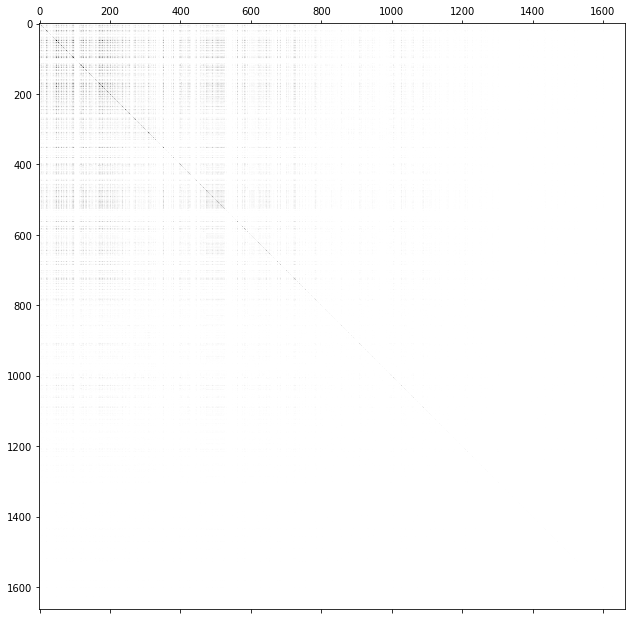

In [142]:
# visualize the matrix
plt.matshow(coMatrix, fignum=1000, cmap=plt.cm.binary)
plt.gcf().set_size_inches(18.5, 10.5)
plt.show()

<div class="alert alert-success">
**QUESTION:** Can you think of a better way of visualizaing this matrix? Try to rescale it, or to rearrenge it follwoing some criteria (for instance, popularity!).
</div>

In [ ]:
mostRatedMovies

C:\Users\J.H\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.


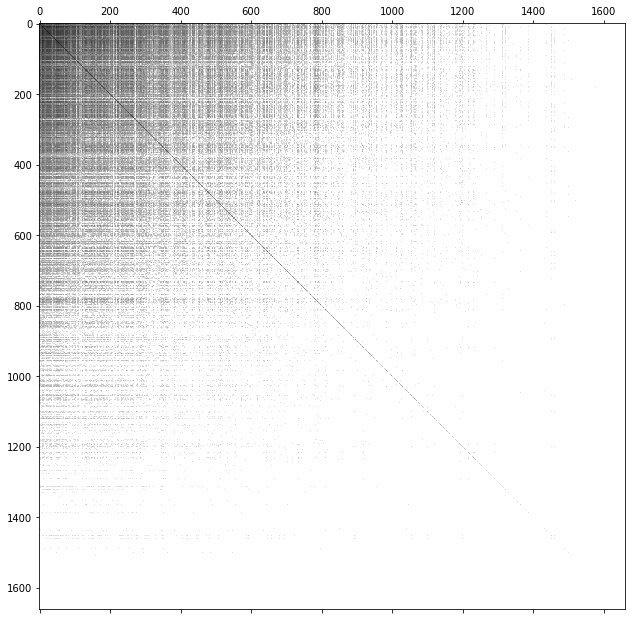

In [150]:
popular_indexing = mostRatedMovies[:,0].astype(int)
coMatrix_sorted = coMatrix[:,popular_indexing]
coMatrix_sorted_columns = coMatrix_sorted[popular_indexing,:]
plt.matshow(np.log(coMatrix_sorted_columns), fignum=1000, cmap=plt.cm.binary)
plt.gcf().set_size_inches(18.5, 10.5)
plt.show()

In [ ]:
# better plot it in log scale!
<fill in>
plt.gcf().set_size_inches(18.5, 10.5)
plt.show()

### 4.1.1 Making predictions using the co-occurrence matrix

This kind of recommendations, based on item similarity, provide a measure of the closeness of one item to another. In order to make a recommendation for a user, we have to proceed as follows:

* First, define a function that returns the top-N closest items to a given one.
* Then, for a list of items adopted by a specific user, select the top-N items from the lists of top-N closest items to each adopted item.

In [ ]:
def co_occurrance_similarity(item_id, coocurrance, ntop=10):
    """
    Returns the top-N most similar items to a given one, based on the coocurrance matrix
    
    :param item_id: id of input item
    :param cooccurrance: 2-dim numpy array with the co-occurance matrix
    :param ntop: number of items to be retrieved
    
    :return top-N most similar items to the given item_id
    """
    similarItems = <fill in>
    # return indeces of most similar items in descendign order
    mostSimilar = <fill in>
    # remove the first element, as it is the item itslef
    mostSimilar = <fill in>
    
    # return a numpy array with the index and the value of the most similar items
    return <fill in>

In [ ]:
queryMovieId = 23
Ntop = 5
print('For item "%s" top-%s recommendations are:' % (unique_item_dict[queryMovieId], Ntop))

similarItems = co_occurrance_similarity(queryMovieId, coMatrix, Ntop)
# let's print out the first Ntop recommendations
for r in similarItems:
    print(unique_item_dict[r[0]], r[1])

Now, let use this function to make recommendations:

In [ ]:
def co_occurrance_recommendation(items_id, cooccurrance, ntop=10):
    """
    Obtain the list of ntop recommendations based on a list of items (user history of views)
    
    :param items_id: list of items ids
    :param coocurrence: co-ocurrence matrix (numpy 2-dim array)
    :param ntop: top-K items to be retrieved
    
    :return list of ntop items recommended
    """
    # put together all the similar items and its value
    list_sim_items = <fill in>
    # sort by value in descending order
    sorted_list = <fill in>
    # We have to remove duplicates
    unique_items = <fill in>
    return unique_items

In [ ]:
# get users in train with their movies
trainUsersGrouped = <fill in>
trainUsersGrouped.head()

In [ ]:
# get the recommendation for a single user
co_occurrance_recommendation(trainUsersGrouped[1], coMatrix, 3)

In [ ]:
Ntop = 10
# Do the same for all users using the apply method
predictions = trainUsersGrouped.<fill in>
predictions[:4]

In [ ]:
for (seen, recom) in zip(testUsersGrouped, predictions)[:3]:
    print("*"*6)
    print("Seen items: ")
    print([unique_item_dict[i] for i in seen])
    print("Recommended items: ")
    print([unique_item_dict[i] for i in recom])

### Evalute the recommendation

In [ ]:
topN = 30
# get predictions
predictions = trainUsersGrouped.<fill in>

# join the list of movies seen by users and their predicitons
targets_predictions = <fill in>
# average recall across all users
recall = <fill in>
# average map across all users
map_ = <fill in>

print("Recall=%.3f; MAP=%.3f" %(recall, map_))

<div class = "alert alert-info">
Compare this results to those obtained with the popularity model. Was it so bad?
</div>

### 4.1.2 Oher distances

So far, we have defined the *closeness* of two items as the number of users shared. However, it would make make sense to define it relative the total number of users that have watch a movie. This can be done with the [Jaccard similarity index](https://en.wikipedia.org/wiki/Jaccard_index):

$$J(i,j)=\frac{|i\cap j|}{|i|+|j|-|i\cap j|}\in [0,1]$$


<div class = "alert alert-success">
Build the Jaccard similarity matrix from the co-occurrance matrix. Notice that $CoM(i,j) = |i\cap j|$ and $CoM(i,i) = |i|$
</div>

In [ ]:
jaccard = np.zeros((n_items, n_items)) # Jaccard similarity matrix
for i, row in enumerate(coMatrix):
    if row[i]==0:
        <fill in>
    else:
        <fill in>

In [ ]:
# visualize the matrix
plt.matshow(jaccard, fignum=1000, cmap=plt.cm.binary)
plt.gcf().set_size_inches(18.5, 10.5)
plt.show()

In [ ]:
popular_indexing = <fill in>
jaccard_sorted = <fill in>
plt.matshow(<fill in>, fignum=1000, cmap=plt.cm.binary)
plt.gcf().set_size_inches(18.5, 10.5)
plt.show()

In [ ]:
queryMovieId = 23
Ntop = 5
print('For item "%s" top-%s similar items are:' % (unique_item_dict[queryMovieId], Ntop))

similarItems = <fill in>
# let's print out the first Ntop recommendations
for r in similarItems:
    print(unique_item_dict[r[0]], r[1])

In [ ]:
Ntop = 10
# Calculate the predictoins with Jaccard
predictions = trainUsersGrouped.<fill in>
predictions[:4]

In [ ]:
for (seen, recom) in zip(testUsersGrouped, predictions)[:3]:
    print("*"*6)
    print("Seen items: ")
    print([unique_item_dict[i] for i in seen])
    print("Recommended items: ")
    print([unique_item_dict[i] for i in recom])

### Evaluate the recommendations

In [ ]:
topN = 30
# get predictions
predictions = trainUsersGrouped.<fill in>


# join the list of movies seen by users and their predicitons
targets_predictions = <fill in>
# average recall across all users
recall = <fill in>
# average map across all users
map_ = <fill in>

print("Recall=%.3f; MAP=%.3f" %(recall, map_))

<div class = "alert alert-info">
** QUESTION **: Can you think of any other way of using the graph of items?
Some hints:

<br></br>
Page Rank
<br></br>
Shortest-path
<br></br>
Clustering methods: eigenvalues, spectral mehtods, etc.
</div>

<a id='memory-base'></a>
## 4.2. Memory-Based Collaborative Filtering (CF)

Although the methods developed so far return a list of recommended items, they cannot be used to make an actual prediction regarding the rating. A quite different approach would be to calculate the unknown rating, $r_{ui}$, as the averaged of some other ratings, thta are somehow close to either the user or the item in question. 

Thus, one approach is to take

### $$r_{u,i} = \frac{1}{K}\sum_{j\in\mathcal{I}'} \mathrm{sim}(i,j) r_{u,j},$$

where items $j\in\mathcal{I}'$ are taken from the set of $K$ closest items to $i$, or from the whole dataset. This is known as **item-item collaborative filtering**, and can be interpreted as *“users who liked this movie also liked …”*. See Amazon famous patent: https://www.google.com/patents/US7113917. Basically, this technique will take an item, find users who liked that item, and find other items that those users or similar users also liked. 

Similarly, one can define a **user-user filtering** where predictions are made as

### $$r_{u,i} = \frac{1}{K} \sum_{v\in\mathcal{U}'} \mathrm{sim}(u,v) r_{v,i}.$$

<img src="https://soundsuggest.files.wordpress.com/2013/06/utility_matrix.png" alt="utility matrix" style="float: right; width: 400px"/>

In this case, the recommendation would be more like *“users who are similar to you also liked …”*. Both techniques are part of the broad familiy of **Memory-Based Collaborative Filtering** approaches, or neighborhood-based algorithms.

The similarity among users or items can be calculated in a variety of forms: Pearson's correlation, cosine distance, etc. Here we will use the cosine distance. For this, we will first create the utility user-item matrix. 

The utility matrix is a dense representation of the user-item intearction. We have been using the *long* format, where missing entries are obviated; now, we will use the *wide* format, i.e. the matrix representation (see the figure on the right). 

<br></br>
<div class = "alert alert-info">
** NOTE **: Long and wide formats have its benefits and drawbacks. Can you think of some of them?
</div>

In [ ]:
train.values[:,0:3]

Put the train and test datasets in wide format (i.e., like a matrix)

In [ ]:
uMatrixTraining = np.zeros((n_users, n_items)) # utility matrix
for row in train.values[:,0:3]:
    # Note ids start at 1
    <fill in>
    
uMatrixTesting = np.zeros((n_users, n_items)) # utility matrix
for row in test.values[:,0:3]:
    # Note ids start at 1
    <fill in>

### Define a similarity measure: cosine similarity

### $$\mathrm{sim}({\bf a},{\bf b})=\frac{{\bf a}\cdot{\bf b}}{\sqrt{{\bf a}\cdot{\bf a}}\sqrt{{\bf  b}\cdot{\bf b}}}$$

In [ ]:
def cosineSimilarity(ratings, kind='user', epsilon=1e-9):
    """
    Calculate the cosine distance along the row (columns) of a matrix for users (items)
    
    :param ratings: a n_user X n_items matrix
    :param kind: string indicating whether we are in mode 'user' or 'item'
    :param epsilon: a small value to avoid dividing by zero (optional, defaults to 1e-9)
    
    :return a square matrix with the similarities
    """
    # epsilon -> small number for handling dived-by-zero errors
    if kind == 'user':
        sim = <fill in>
    elif kind == 'item':
        sim = <fill in>
    norms = <fill in>
    return sim / norms / norms.T

### 4.2.1. User-user CF

*“Users who are similar to you also liked …”*

Consider user $x$:

1. Find other users whose ratings are “similar” to $x$’s ratings, i.e. calculate the similarity among users
2. Estimate missing ratings based on ratings of similar users

In [ ]:
# we use cosine similarity
userSimilarity = cosineSimilarity(uMatrixTraining, kind='user')
userSimilarity.shape

In [ ]:
userItemCFpredictions = <fill in>

In [ ]:
# Be careful: take a look at the values
np.max(userItemCFpredictions)

### 4.2.2. Item-Item CF

*“Users who liked this movie also liked …”*

Consider item $i$:

1. For item $i$, find other similar items, i.e. calculate the similarity among items
2. Estimate rating for item $i$ based on ratings for similar items



In [ ]:
# we use cosine similarity
itemSimilarity = cosineSimilarity(uMatrixTraining, kind='item')
print(itemSimilarity.shape)
itemItemCFpredictions = uMatrixTraining.dot(itemSimilarity)

<div class="alert alert-danger">
**QUESTION:** Is averaging across all users or items computationally efficent? 
<br></br>
<br></br>
This is why nearest-neighbourghs methods (**KNN**) exists
</div>

### 4.2.3 Show some recommendations

In case of item-item CF, the recommendation is pretty much the same as with the co-occurence matrix. It's also quite simple to find similar items to a given one.

<div class="alert alert-success">
Find movies similar to a given one using the item-item similarity matrix.
</div>

In [ ]:
queryMovieId = 720
print("Select item is '%s'" % unique_item_dict[queryMovieId])


queryAnswer = <fill in>
queryAnswer = <fill in> #descending order
queryAnswer = <fill in>  # remove first item (itself)

# let's print out the most similar items
print("Most similar movies are:")
printAnswer = queryAnswer[0:10]
for answerId in printAnswer:
    print unique_item_dict[answerId]

<div class="alert alert-success">
Calculate the recommendations obtained with the item-item CF model.
</div>

In [ ]:
# Remove relevant items seen in train from our prediction:
itemItemCFpredictions[uMatrixTraining>=4.0] = 0.0

In [ ]:
for u in np.random.randint(0, n_users, 3):
    print("*"*6)
    print("User %s" % u)
    print("Seen items: ")
    seen = uMatrixTesting[u,:]
    print([unique_item_dict[i] for i,r in enumerate(seen) if r>4.0])
    print("Recommended items: ")
    recom = itemItemCFpredictions[u,:]
    recom = np.argsort(recom)[::-1][:10]
    print([unique_item_dict[i] for i in recom])

<div class="alert alert-success">
Do the same with the user-user CF model.
</div>

### 4.2.4 Measure the recommendations

Since we are predicting ratings, it might make sense to introduce a metric that accounts for this. In particular, the **Root Mean Square Error (RMSE)** is typically used for this purpose. 

### $$\mathrm{RMSE}=\sqrt{\frac{1}{n_{\mathrm{users}}n_{\mathrm{items}}}\sum_{u,i}\left(r_{u,i}-\hat{r}_{u,i}\right)^2}$$

In [ ]:
from math import sqrt
def rmse(prediction, ground_truth):
    """
    Return the Root Mean Squared Error of the prediction
    
    :param prediction: a 2-dim numpy array with the predictions
    :param ground_truth: a 2-dim numpy array with the known ratings
    
    :return the RMSE
    """
    return sqrt(np.mean(np.power(prediction-ground_truth, 2.0)))

In [ ]:
print('User-based CF RMSE=%.3f' %rmse(userItemCFpredictions, uMatrixTesting))

In [ ]:
print('Item-based CF RMSE=%.3f' %rmse(itemItemCFpredictions, uMatrixTesting))

<div class = "alert alert-danger">
**IMPORTANT TO NOTE**: RMSE was used in the RecSys community for many years to measure the accuracy 
of recommendations. However, it was demonstrated that high accuracy in predicting rating does not imply a good
ranked list!!    
</div>

### Calculate ranking metrics

In [ ]:
Ntop = 30
userItemCFpredictions_sorted = <fill in>

# recall
np.mean([recall_at_n(Ntop,seen, recom) 
         for (seen, recom) in <fill in>])

In [ ]:
Ntop = 30
itemItemCFpredictions_sorted = <fill in>

np.mean([recall_at_n(Ntop,seen, recom) 
         for (seen, recom) in <fill in>])

<a id='model-base'></a>
## 4.3. Model-based CF or Latent factor models
There are several model-based CF: from matrix factorizations to bayesian models, neural netwroks, etc. In all of them, we try to extract latent factors (vectors) that model user and item behaviour. Then, we use this latent features to make a prediction:

## $$r_{u,i} \approx {\bf f}_u^T\cdot{\bf f}_i$$

The underlying assumption is that both users and items *live* in the same latent space, and that we can unravel such space. 

<img src="https://www.researchgate.net/profile/Tunca_Dogan/publication/235913413/figure/fig3/AS:299678856957952@1448460415040/The-distribution-of-the-points-in-the-Swiss-roll-dataset-in-3-D-space.png" alt="swiss roll" style="float: center; width: 300px"/>


Here we will use a couple of linear Matrix Factorization (MF) models:

* Singular Value decomposition (SVD)
* Alternating Least Squares (ALS)

### 4.3.1 Singular value decomposition

The main idea is to reduce the dimensionality of the input space. This is pretty much the same as Eigen-decomposition or Principal Component Analysis (PCA)-

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/f/f5/GaussianScatterPCA.svg/220px-GaussianScatterPCA.svg.png
" alt="dimensionaly reducion" style="float: center; width: 500px"/>


In [ ]:
from scipy.sparse.linalg import svds

In [ ]:
# look at the help!!!
svds??

In [ ]:
#get SVD components from train matrix. Choose k.
k=20
u, s, vt = svds(uMatrixTraining, k)

In [ ]:
# take a look at the different matrices

# U should be an orthogonal matrix with the left singular vectors as columns
print(u.shape)
# Check U is orthogonal
print(rmse(np.dot(u.T,u), np.identity(k)))

# Same with V
print(vt.shape)
print(rmse(np.dot(vt,vt.T), np.identity(k)))

# s is a vector with the singular values
print(s)

### Get the recommendations

We will reconstruct the utility matrix R as follows:

### $$M\approx U\mathrm{diag}(s)V^T$$

In [ ]:
# Build a diagonal matrix with the eigenvalues
s_diag_matrix = np.diag(s)

# make the prediction
svdPredictions = np.dot(np.dot(u, s_diag_matrix), vt)

In [ ]:
# check the dimensions are correct
print(svdPredictions.shape)
print(uMatrixTesting.shape)

### Evaluate the model

* RMSE
* Recall@30
* MAP@30

In [ ]:
print('SVD RMSE=%.3f' % rmse(svdPredictions, uMatrixTesting))

In [ ]:
# recall
np.mean([recall_at_n(<fill in>) for target, rec in <fill in>])

<div class = "alert alert-danger">
**IMPORTANT TO NOTE**: RMSE was used in the RecSys community for many years to measure the accuracy 
of recommendations. However, it was demonstrated that high accuracy in predicting rating does not imply a good
ranked list!!    
</div>

### 3.2 Alternating Least Squares (ALS)

SVD can be very slow and computationally expensive. Besides, when addressing only the relatively few known entries we are highly prone to overfitting.

An scalable alternative to SVD is ALS, which can include regularization terms to prevent overfitting. We will rename our variable to make them more similar to the ALS notation

In [ ]:
R = uMatrixTraining
T = uMatrixTesting

### Implicit vs Explicit feedback
Now we define a “selector” matrix $I$ for the training utility matrix $R$, which will contain 0 if the rating matrix has no rating entry, and 1 if the rating matrix contains an entry. 


In [ ]:
# Index matrix for training data
I = R.copy()
I[I > 3] = 1
I[I == 0] = 0

# Index matrix for test data
I2 = T.copy()
I2[I2 > 3] = 1
I2[I2 == 0] = 0

### ALS algorithm

The ALS algorithm aims to estimate two unknown matrices which, when multiplied together, yield the rating matrix. The loss function you will use is the well-known sum of squared errors. The second term is for regularisation to prevent overfitting

<img src="https://latex.codecogs.com/gif.latex?\underset{Q*&space;,&space;P*}{min}\sum_{(u,i)\epsilon&space;K&space;}(r_{ui}-P_u^TQ_i)^2&plus;\lambda(\left&space;\|&space;Q_i&space;\right&space;\|^2&space;&plus;&space;\left&space;\|&space;P_u&space;\right&space;\|^2)$&space;&space;$" title="\underset{q* , p*}{min}\sum_{(u,i)\epsilon K }(r_{ui}-q_i^Tp_u)^2+\lambda(\left \| q_i \right \|^2 + \left \| p_u \right \|^2)" />

The Alternating Least Squares algorithm does this by first randomly filling the users matrix with values and then optimizing the value of the movies such that the error is minimized.  Then, it holds the movies matrix constant and optimizes the value of the user's matrix.  This alternation between which matrix to optimize is the reason for the "alternating" in the name. 

<img alt="factorization" src="http://spark-mooc.github.io/web-assets/images/matrix_factorization.png" style="width: 885px"/>
<br clear="all"/>

This optimization is what's being shown on the right in the image above.  Given a fixed set of user factors (i.e., values in the users matrix), we use the known ratings to find the best values for the movie factors using the optimization written at the bottom of the figure.  Then we "alternate" and pick the best user factors given fixed movie factors.

It must be noticed that this is another way of reducing the dimensionality of the input matrix (like PCA, or more generally, SVD). This has important consequences:

* ### Our decomposition is linear. We won't be able to catch non-linear relationships among users and items.
* ### As in PCA or SVD, our features will correspond to directions of maximum variance in the data. Thus, the first feature will catch most of this variation, the second, a little bit more, and so on. It implies that the error in the reconstruction will not decrease dramatically when using more features!!! Keep this in mind.


In [ ]:
def alsRmse(I,R,Q,P):
    return np.sqrt(np.sum((I * (R - np.dot(P.T,Q)))**2)/len(R[R > 0]))

In [ ]:
# Algorithm free parameters
lmbda = 0.1     # Regularisation weight
k = 20          # Dimensionality of latent feature space
m, n = R.shape  # Number of users and items
n_epochs = 15   # Number of epochs

# Initialization
P = 3 * np.random.rand(k,m) # Latent user feature matrix
Q = 3 * np.random.rand(k,n) # Latent movie feature matrix
Q[0,:] = R[R != 0].mean(axis=0) # Avg. rating for each movie
E = np.eye(k) # (k x k)-dimensional idendity matrix

In [ ]:
train_errors = []
test_errors = []

# Repeat until convergence
for epoch in range(n_epochs):
    # Fix Q and estimate P
    for i, Ii in enumerate(I):
        nui = np.count_nonzero(Ii) # Number of items user i has rated
        if (nui == 0): nui = 1 # Be aware of zero counts!
    
        # Least squares solution
        Ai = np.dot(Q, np.dot(np.diag(Ii), Q.T)) + lmbda * nui * E
        Vi = np.dot(Q, np.dot(np.diag(Ii), R[i].T))
        P[:,i] = np.linalg.solve(Ai,Vi)
        
    # Fix P and estimate Q
    for j, Ij in enumerate(I.T):
        nmj = np.count_nonzero(Ij) # Number of users that rated item j
        if (nmj == 0): nmj = 1 # Be aware of zero counts!
        
        # Least squares solution
        Aj = np.dot(P, np.dot(np.diag(Ij), P.T)) + lmbda * nmj * E
        Vj = np.dot(P, np.dot(np.diag(Ij), R[:,j]))
        Q[:,j] = np.linalg.solve(Aj,Vj)
    
    train_rmse = alsRmse(I,R,Q,P)
    test_rmse = alsRmse(I2,T,Q,P)
    train_errors.append(train_rmse)
    test_errors.append(test_rmse)
    
    print "[Epoch %d/%d] train error: %f, test error: %f" \
    %(epoch+1, n_epochs, train_rmse, test_rmse)
    
print "Algorithm converged"

In [ ]:
# Check performance by plotting train and test errors
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(range(n_epochs), train_errors, marker='o', label='Training Data');
plt.plot(range(n_epochs), test_errors, marker='v', label='Test Data');
plt.title('ALS-WR Learning Curve')
plt.xlabel('Number of Epochs');
plt.ylabel('RMSE');
plt.legend()
plt.grid()
plt.show()

### ALS predictions

In [ ]:
alsPredictions = np.dot(P.T,Q)

svdPredictions = np.dot(np.dot(u, s_diag_matrix), vt)
print 'ALS CF RMSE: ' + str(rmse(alsPredictions, uMatrixTesting))
print 'SVD CF RMSE: ' + str(rmse(svdPredictions, uMatrixTesting))

In [ ]:
queryAnswer = alsPredictions[queryUser,noWatchedMovies]
queryAnswer = noWatchedMovies[np.argsort(queryAnswer)[::-1]] #descending order

print 'so, it is expected he/she also likes ... '
print ' '

printAnswer = queryAnswer[0:11]
for answerId in printAnswer:
    print idx_to_movie[answerId]

<div class = "alert alert-info">
What about MAP and Recall metrics?
</div>

<div class = "alert alert-info">
Try different dimensions for the latent feature space? what do you observe?
</div>

<a id='exercises'></a>
## 4. Exercises (advanced)

<div class = "alert alert-success">
**E1:** Implement centered cosine similarity metric in [Section 2](#cf)
</div>

<div class = "alert alert-success">
**E2:** Implement global baseline biased in [Section 2](#cf): $b_{ui} = \mu + b_u + b_i$
</div>

<div class = "alert alert-success">
**E3:** Implement k-neighbors in [Section 2](#cf)
</div>

Take a look at http://infolab.stanford.edu/~ullman/mmds/ch9.pdf